In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from causalml.inference.tree import UpliftRandomForestClassifier
from sklift.metrics import uplift_at_k
import skopt
from collections import defaultdict
%matplotlib inline

In [2]:
train_df = pd.read_csv('minethatdata_womens_train.csv')
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21346 entries, 0 to 21345
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   index            21346 non-null  int64  
 1   recency          21346 non-null  int64  
 2   history_segment  21346 non-null  object 
 3   history          21346 non-null  float64
 4   mens             21346 non-null  int64  
 5   womens           21346 non-null  int64  
 6   zip_code         21346 non-null  object 
 7   newbie           21346 non-null  int64  
 8   channel          21346 non-null  object 
 9   segment          21346 non-null  object 
 10  visit            21346 non-null  int64  
 11  conversion       21346 non-null  int64  
 12  spend            21346 non-null  float64
dtypes: float64(2), int64(7), object(4)
memory usage: 2.1+ MB


In [3]:
test_df = pd.read_csv('minethatdata_womens_test_no_answers.csv')
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21347 entries, 0 to 21346
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   index            21347 non-null  int64  
 1   recency          21347 non-null  int64  
 2   history_segment  21347 non-null  object 
 3   history          21347 non-null  float64
 4   mens             21347 non-null  int64  
 5   womens           21347 non-null  int64  
 6   zip_code         21347 non-null  object 
 7   newbie           21347 non-null  int64  
 8   channel          21347 non-null  object 
 9   segment          21347 non-null  object 
dtypes: float64(1), int64(5), object(4)
memory usage: 1.6+ MB


In [4]:
whole_df = pd.concat([train_df.assign(sample='train'),
                      test_df.assign(sample='test'),],
                     ignore_index=True)
whole_df.head()

,index,recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend,sample
0,54222,10,1) $0 - $100,29.99,0,1,Surburban,1,Phone,No E-Mail,0.0,0.0,0.0,train
1,30074,6,3) $200 - $350,292.39,0,1,Rural,0,Phone,Womens E-Mail,0.0,0.0,0.0,train
2,2725,8,1) $0 - $100,35.57,1,0,Surburban,0,Phone,No E-Mail,0.0,0.0,0.0,train
3,52884,1,1) $0 - $100,75.64,1,0,Surburban,1,Web,No E-Mail,0.0,0.0,0.0,train
4,42004,4,1) $0 - $100,29.99,1,0,Surburban,1,Web,Womens E-Mail,0.0,0.0,0.0,train


In [5]:
targets_list = ['visit',
                'conversion',
                'spend',]

<AxesSubplot:xlabel='segment', ylabel='count'>

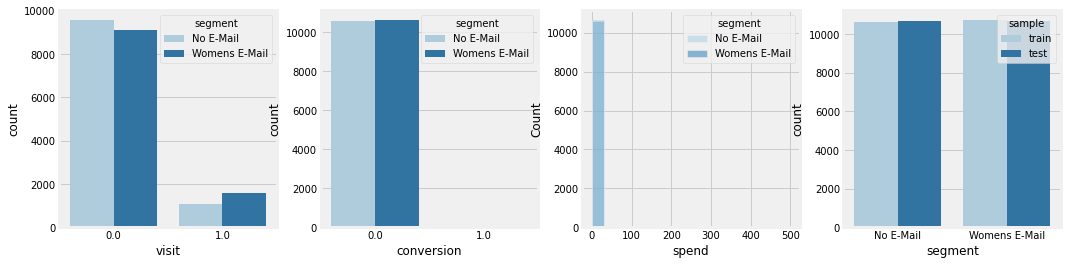

In [6]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(16, 4))
sns.countplot(x='visit',
              hue='segment',
              data=whole_df,
              ax=axs[0])
sns.countplot(x='conversion',
              hue='segment',
              data=whole_df,
              ax=axs[1])
sns.histplot(x='spend',
             hue='segment',
             data=whole_df,
             ax=axs[2])
sns.countplot(x='segment',
              hue='sample',
              data=whole_df,
              ax=axs[3])

<AxesSubplot:xlabel='spend', ylabel='Count'>

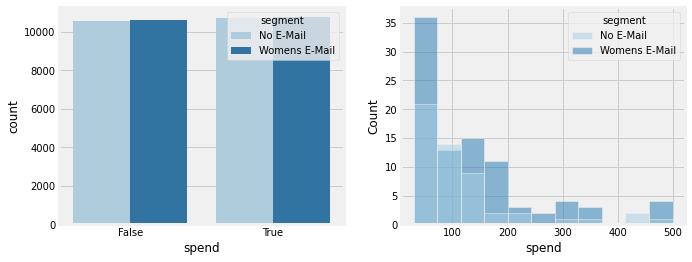

In [7]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

mask = whole_df['spend'] != 0 
sns.countplot(x=mask,
              hue=whole_df['segment'],
              ax=axs[0])
sns.histplot(x='spend',
             hue='segment',
             data=whole_df[mask],
             ax=axs[1])

In [8]:
treatment_mask = train_df['segment'] == 'Womens E-Mail'
statistics = defaultdict(list)
for target in targets_list:
    yt_mean = train_df.loc[treatment_mask, target].mean()
    yc_mean = train_df.loc[~treatment_mask, target].mean()
    ate_abs = yt_mean - yc_mean
    ate_rel = yt_mean / yc_mean

    statistics['variable'].append(target)
    statistics['mean_control'].append(yc_mean)
    statistics['mean_treated'].append(yt_mean)
    statistics['ate'].append(ate_abs)
    statistics['relative_change'].append(ate_rel)
statistics_df = pd.DataFrame.from_dict(statistics)
statistics_df.to_csv('statistics.csv', index=False)
statistics_df

,variable,mean_control,mean_treated,ate,relative_change
0,visit,0.101720,0.148193,0.046473,1.456867
1,conversion,0.004983,0.008498,0.003515,1.705437
2,spend,0.583971,1.131093,0.547121,1.936898


In [9]:
n_treatment = n_control = 5000
n_iter = 30
yc_means = defaultdict(list)
ates = defaultdict(list)
relative_changes = defaultdict(list)
np.random.seed(110894)
for target in targets_list:
    for i in range(n_iter):
        t_idxs = np.random.choice(train_df[treatment_mask].index,
                                  size=n_treatment)
        c_idxs = np.random.choice(train_df[~treatment_mask].index,
                                  size=n_control)
        yt_mean = train_df[treatment_mask].loc[t_idxs,  target].mean()
        yc_mean = train_df[~treatment_mask].loc[c_idxs,  target].mean()
        ate = yt_mean - yc_mean
        ate_rel = yt_mean / yc_mean

        ates[target].append(ate)
        relative_changes[target].append(ate_rel)
        yc_means[target].append(yc_mean)

for target in targets_list:
    ate_vals = np.array(ates[target])
    ate_low = ate_vals.mean() - 2 * ate_vals.std()
    ate_hight = ate_vals.mean() + 2 * ate_vals.std()
    print(f'ate {target:23}: {ate_low},{ate_hight}')

    ate_rel_vals = np.array(relative_changes[target])
    ate_rel_low = ate_rel_vals.mean() - 2 * ate_rel_vals.std()
    ate_rel_hight = ate_rel_vals.mean() + 2 * ate_rel_vals.std()
    print(f'relative change {target:11}: {ate_rel_low},{ate_rel_hight}')

ate visit                  : 0.03412468404555159,0.05992864928778174
relative change visit      : 1.3113000936531103,1.6262561403937825
ate conversion             : 0.0007941438160388461,0.00611252285062782
relative change conversion : 0.98693974184737,2.4864500719355043
ate spend                  : -0.13883982543437468,1.2500387587677082
relative change spend      : 0.11825286711801297,4.273431551124024


In [10]:
features_list = ['recency',
                 'history_segment',
                 'history',
                 'mens',
                 'womens',
                 'zip_code',
                 'newbie',
                 'channel',]

In [11]:
whole_df[features_list].describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
recency,42693.0,NaN,NaN,NaN,5.758789,3.504745,1.0,2.0,5.0,9.0,12.0
history_segment,42693,7,1) $0 - $100,15246,NaN,NaN,NaN,NaN,NaN,NaN,NaN
history,42693.0,NaN,NaN,NaN,241.711212,254.040262,29.99,65.16,158.46,326.05,3345.93
mens,42693.0,NaN,NaN,NaN,0.551074,0.49739,0.0,0.0,1.0,1.0,1.0
womens,42693.0,NaN,NaN,NaN,0.548872,0.497612,0.0,0.0,1.0,1.0,1.0
zip_code,42693,3,Surburban,19275,NaN,NaN,NaN,NaN,NaN,NaN,NaN
newbie,42693.0,NaN,NaN,NaN,0.502612,0.499999,0.0,0.0,1.0,1.0,1.0
channel,42693,3,Phone,18781,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
category_features_list = ['history_segment',
                          'zip_code',
                          'channel',]
discrete_features_list = ['mens',
                          'womens',
                          'newbie',]
numeric_features_list = ['recency',
                         'history',]

FixedFormatter should only be used together with FixedLocator


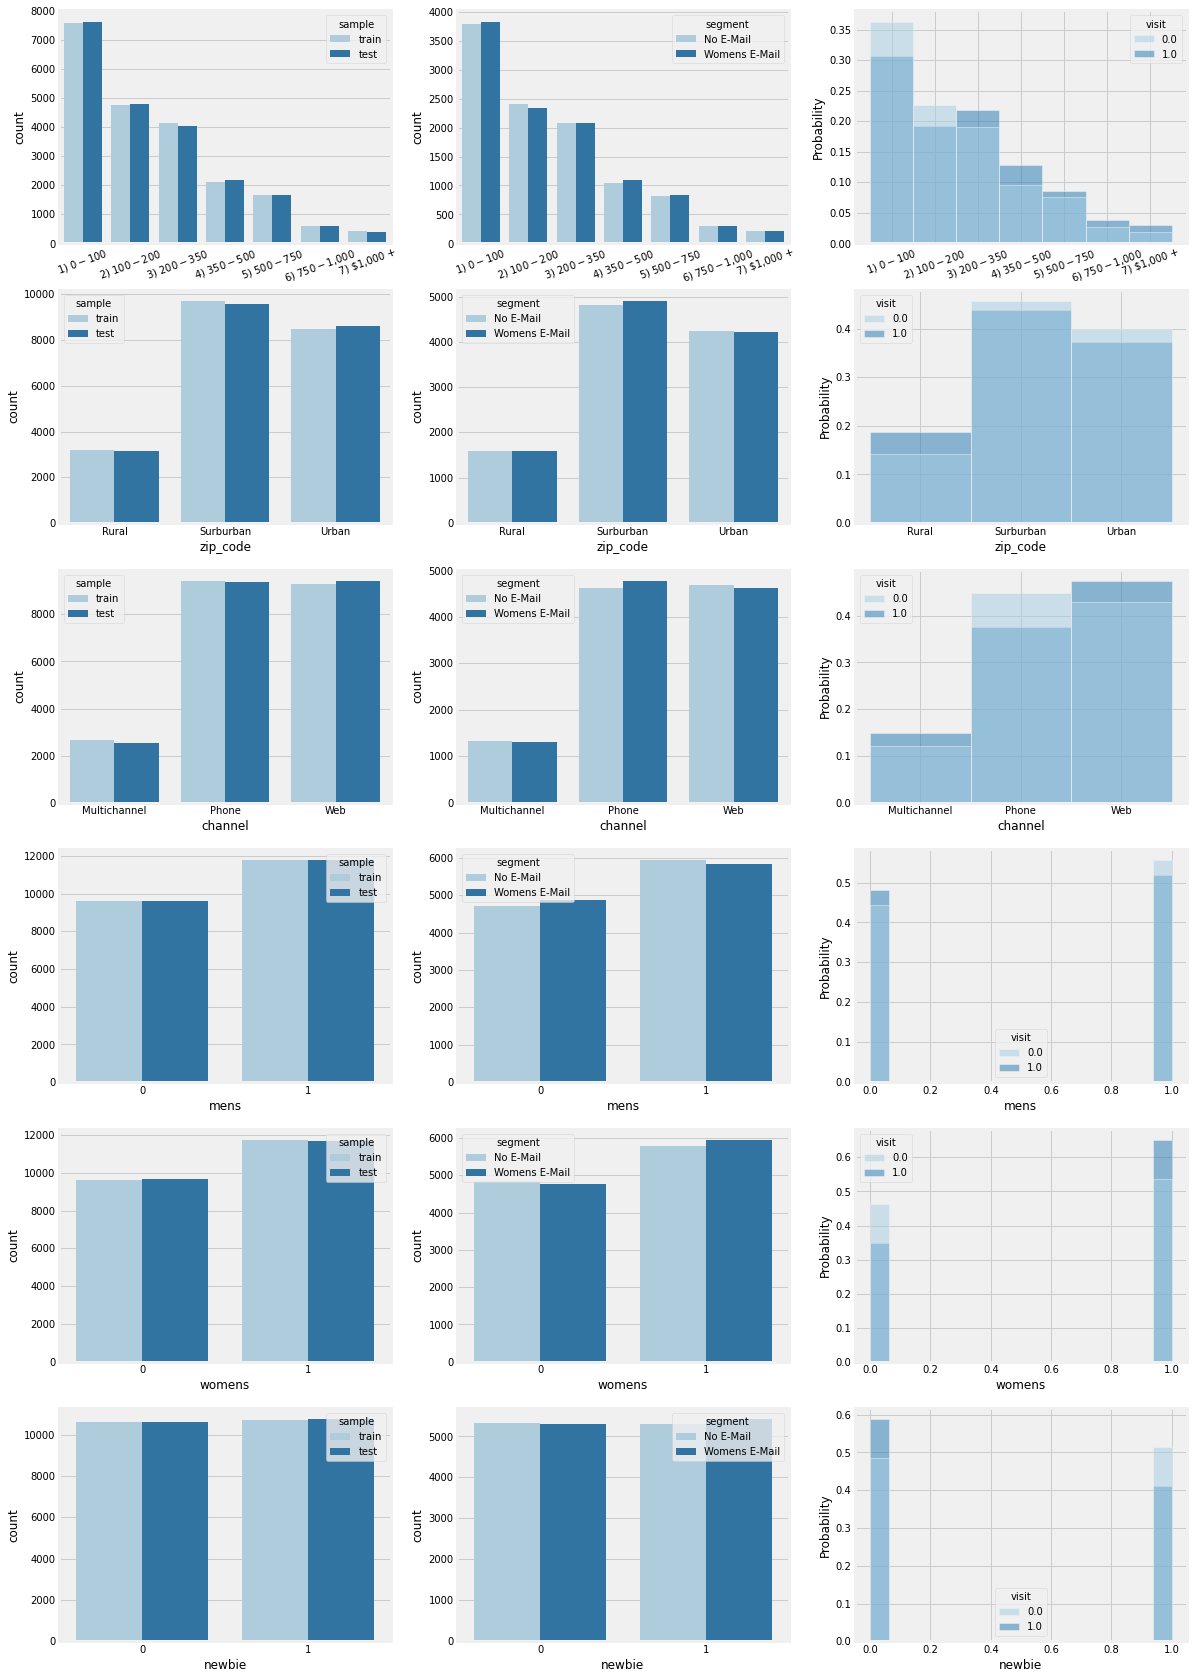

In [13]:
fig, axs = plt.subplots(nrows=6, ncols=3, figsize=(18, 30))
for i, feature in enumerate(category_features_list 
                            + discrete_features_list):
    values = list(sorted(whole_df[feature].unique()))
    if i == 0:
        for j in range(3):
            _ = axs[i][j].set_xticklabels(values,
                                          rotation=20)
    sns.countplot(x=feature,
                  hue='sample',
                  order=values,
                  data=whole_df,
                  ax=axs[i][0],)
    mask = whole_df['sample'] == 'train'
    sns.countplot(x=feature,
                  hue='segment',
                  order=values,
                  data=whole_df[mask],
                  ax=axs[i][1],)
    sns.histplot(x=feature,
                 hue='visit',
                 stat='probability',
                 common_norm=False,
                 data=whole_df[mask].sort_values(feature),
                 ax=axs[i][2],)

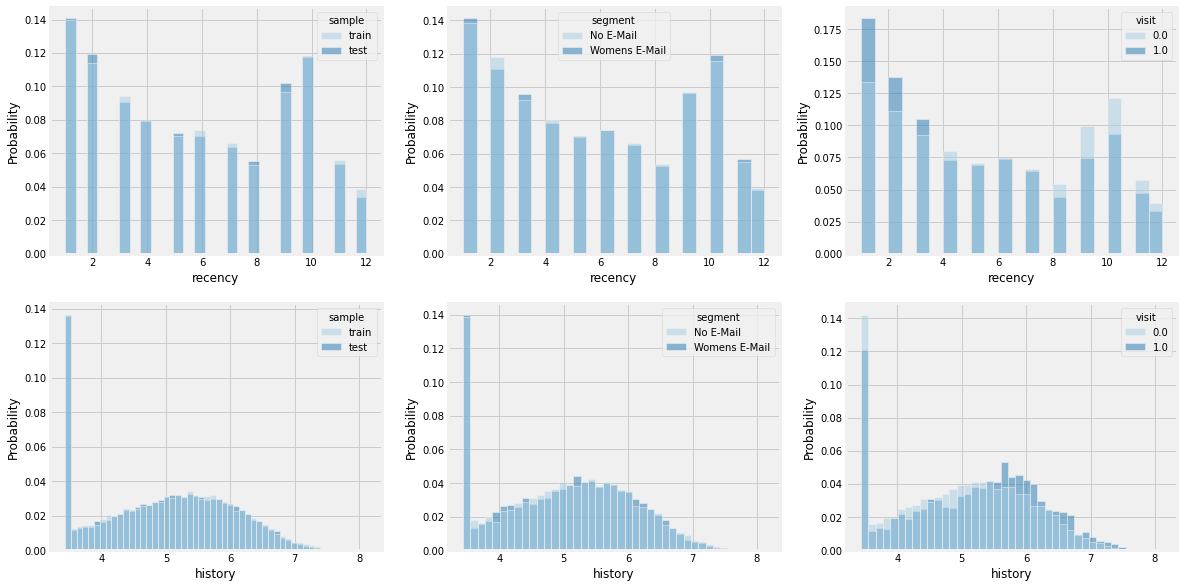

In [14]:
fig, axs = plt.subplots(nrows=len(numeric_features_list),
                        ncols=3,
                        figsize=(18, 10))
for i, feature in enumerate(numeric_features_list):
    feature_ss = whole_df[feature]
    if i == 1:
        feature_ss = whole_df[feature].map(np.log1p)
    
    sns.histplot(x=feature_ss,
                 hue='sample',
                 stat='probability',
                 common_norm=False,
                 data=whole_df,
                 ax=axs[i][0],)
    mask = whole_df['sample'] == 'train'
    sns.histplot(x=feature_ss,
                 hue='segment',
                 stat='probability',
                 common_norm=False,
                 data=whole_df[mask],
                 ax=axs[i][1],)
    sns.histplot(x=feature_ss[mask],
                 hue='visit',
                 stat='probability',
                 common_norm=False,
                 data=whole_df[mask],
                 ax=axs[i][2],)

In [15]:
whole_df[features_list].corr(method='kendall')

,recency,history,mens,womens,newbie
recency,1.000000,-0.165332,-0.522819,-0.522234,-0.532658
history,-0.165332,1.000000,-0.441936,-0.439749,-0.444994
mens,-0.522819,-0.441936,1.000000,-0.956718,-0.489443
womens,-0.522234,-0.439749,-0.956718,1.000000,-0.483825
newbie,-0.532658,-0.444994,-0.489443,-0.483825,1.000000


In [16]:
def preprocess(input_df: pd.DataFrame) -> pd.DataFrame:
    preproc_df = input_df.copy()

    preproc_df['history_segment'] = preproc_df['history_segment'].str[0].astype(int)
    preproc_df['zip_code'] = preproc_df['zip_code'].map({'Rural': 0,
                                                         'Surburban': 1,
                                                         'Urban': 2,})
    for channel in ['Phone', 'Web', 'Multichannel']:
        preproc_df[f'channel_{channel}'] = (preproc_df['channel'] == channel).astype(int)
    del preproc_df['channel']
    
    preproc_df['history'] = preproc_df['history'].map(np.log1p)

    return preproc_df
train_preproc_df = preprocess(train_df)
test_preproc_df = preprocess(test_df)

In [17]:
features_list.remove('channel')
features_list.extend(['channel_Web',
                      'channel_Multichannel',
                      'channel_Phone',])
features_list

['recency',
 'history_segment',
 'history',
 'mens',
 'womens',
 'zip_code',
 'newbie',
 'channel_Web',
 'channel_Multichannel',
 'channel_Phone']

In [18]:
X_train, w_train, y_train = (train_preproc_df.loc[:, features_list].values,
                             train_preproc_df.loc[:, 'segment'].map({'Womens E-Mail': 'treatment',
                                                                     'No E-Mail': 'control',}).values,
                             train_preproc_df.loc[:, 'visit'].values,)
X_train.shape, w_train.shape, y_train.shape

((21346, 10), (21346,), (21346,))

In [19]:
(X_train, X_valid,
 w_train, w_valid,
 y_train, y_valid,) = train_test_split(X_train, w_train, y_train,
                                       test_size=0.3,
                                       stratify=w_train,
                                       random_state=110894)
X_train.shape, X_valid.shape

((14942, 10), (6404, 10))

In [20]:
X_test = test_preproc_df.loc[:, features_list].values
X_test.shape

(21347, 10)

In [30]:
history = list()

def train(space):
    model = UpliftRandomForestClassifier(n_estimators=10,
                                         max_depth=space[0],
                                         max_features=space[1],
                                         min_samples_leaf=space[2],
                                         control_name='control',
                                         random_state=110894)
    model.fit(X_train, w_train, y_train)

    uplift_train, uplift_valid = (uplift_at_k(y_train,
                                              model.predict(X_train).reshape(-1),
                                              (w_train == 'treatment').astype(int),
                                              strategy='overall'),
                                  uplift_at_k(y_valid,
                                              model.predict(X_valid).reshape(-1),
                                              (w_valid == 'treatment').astype(int),
                                              strategy='overall'))
    history.append((uplift_train, uplift_valid))
    return -uplift_valid

In [31]:
res_opt = skopt.gp_minimize(train,
                           [(2, 10),
                            (1, len(features_list)),
                            (10, 500),],
                           acq_func="EI",
                           n_calls=50,
                           random_state=110894)
res_opt.fun

The objective has been evaluated at this point before.


-0.09209456603037298

In [32]:
model = UpliftRandomForestClassifier(n_estimators=10,
                                     max_depth=res_opt.x[0],
                                     max_features=res_opt.x[1],
                                     min_samples_leaf=res_opt.x[2],
                                     control_name='control',
                                     random_state=110894)
model.fit(X_train, w_train, y_train)

In [33]:
(pd.DataFrame({'index': test_df['index'].values,
               'score': model.predict(X_test).reshape(-1),})
 .to_csv('uplift.csv', index=False))